# MLP Line-Continuum Classifier

## Introduction

This notebook follows the Text Classification guide from Google Machine Learning Guides.<br/>
This notebook contains all the code that the guide shows in the tutorial and not in its github repo. Hope this guide helps you as you follow the Text Classification guide.

Link to the Guide: https://developers.google.com/machine-learning/guides/text-classification/

In this notebook, we see how to perform sentiment analysis using IMDB Movie Reviews Dataset. We will classify reviews into `2` labels: _positive(`1`)_ and _negetive(`0`)_. And we will encode the data using tf-idf and feed into a Multi-layer Perceptron. We will use tensorflow, with Keras API.

## Loading the required modules

Let;s get started by loading all the required modules and defining all the constants and variables that we will be needing all throughout the notebook

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout

In [2]:
seed = 6040

## Load the Dataset

In this section, let's load the dataset and shuffle it so to make ready for analysis.

In [3]:
def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y

In [4]:
# def load_imdb_dataset(path):
#     imdb_path = os.path.join(path, 'aclImdb')

#     # Load the dataset
#     train_texts = []
#     train_labels = []
#     test_texts = []
#     test_labels = []
#     for dset in ['train', 'test']:
#         for cat in ['pos', 'neg']:
#             dset_path = os.path.join(imdb_path, dset, cat)
#             for fname in sorted(os.listdir(dset_path)):
#                 if fname.endswith('.txt'):
#                     with open(os.path.join(dset_path, fname)) as f:
#                         if dset == 'train': train_texts.append(f.read())
#                         else: test_texts.append(f.read())
#                     label = 0 if cat == 'neg' else 1
#                     if dset == 'train': train_labels.append(label)
#                     else: test_labels.append(label)

#     # Converting to np.array
#     train_texts = np.array(train_texts)
#     train_labels = np.array(train_labels)
#     test_texts = np.array(test_texts)
#     test_labels = np.array(test_labels)

#     # Shuffle the dataset
#     train_texts, train_labels = shuffle(train_texts, train_labels)
#     test_texts, test_labels = shuffle(test_texts, test_labels)

#     # Return the dataset
#     return train_texts, train_labels, test_texts, test_labels

In [5]:
# Read data
full_data = pd.read_csv('../data/nrao_projects.csv')
full_data.head()

,project_code,project_title,project_abstract,fs_type
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line


In [6]:
# Create binary column for classification
full_data['class']  = 0
mask = full_data['fs_type'].str.fullmatch('line')
full_data.loc[mask, 'class'] = 1
full_data.head()

,project_code,project_title,project_abstract,fs_type,class
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1


In [7]:
# Concatenate project title and abstract
full_data['combo_text'] = full_data['project_title'] + '. ' + full_data['project_abstract']
full_data.head()

,project_code,project_title,project_abstract,fs_type,class,combo_text
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1,Fifty AU STudy of the chemistry in the disk/en...
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1,COMPASS: Complex Organic Molecules in Protosta...
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1,ALCHEMI: the ALMA Comprehensive High-resolutio...
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1,ALMA JELLY - Survey of Nearby Jellyfish and Ra...
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1,Bulge symmetry or not? The hidden dynamics of ...


In [8]:
full_data.iloc[1].combo_text

'COMPASS: Complex Organic Molecules in Protostars with ALMA Spectral Surveys. The emergence of complex organic molecules in the interstellar medium is a fundamental puzzle of astrochemistry. Targeted observations with ALMA have opened the door to high-sensitivity spectral surveys over wide bandwidths to elucidate the chemical complexity of young stars in a systematic manner. We propose a Large Program to perform unbiased line surveys in the 279 to 312 GHz frequency range of 11 nearby Solar-type protostars. The targeted protostars are known hosts of complex organic molecules and sample different natal environments and evolutionary stages. The proposed spectral coverage will allow us to unambiguously identify complex organic molecules and their isotopologues and to accurately derive the abundances for species with abundances down to 0.01% relative to methanol. The concerted effort will provide a deep understanding of the complex organic inventories and isotopic ratios depending on the ph

In [9]:
full_data.shape

(4528, 6)

In [10]:
# train test split
trX, ttX, trY, ttY = train_test_split(full_data['combo_text'], full_data['class'], test_size=500, random_state=seed)

In [11]:
trY

706     1
4072    1
2551    1
4424    0
3768    1
       ..
238     1
4243    1
1862    1
2413    1
242     1
Name: class, Length: 4028, dtype: int64

In [12]:
trX = trX.str.replace("\'", '')
ttX = ttX.str.replace("\'", '')

In [13]:
trX = trX.to_numpy()
ttX = ttX.to_numpy()
trY = np.float32(trY)
ttY = np.float32(ttY)

In [14]:
list(trX)

['The C content of debris disks around young A-stars. A growing number of debris disks are found to contain gas, but the origin and evolution of this gas is not well understood. We propose to acquire ALMA data of CI emission towards seven debris disks. By combining our observations with archival data, we will get a complete census of the C and CO gas content of a volume-limited sample of bright debris disks around young A-stars. This will allow us to study the relation between C, CO and the dust on a statistical level for the first time. By comparing the fluxes and spatial distributions of C, CO and the dust, we will test models of secondary gas production, viscous evolution and chemistry of gaseous debris disks. Our survey will provide new insights into the early evolution of planetary systems and help to bridge the gap between protoplanetary disks and mature planetary systems such as the Solar System.',
 'Resolving GMC Scales and Clumpy Galaxy Formation in the Most Massive Halo in th

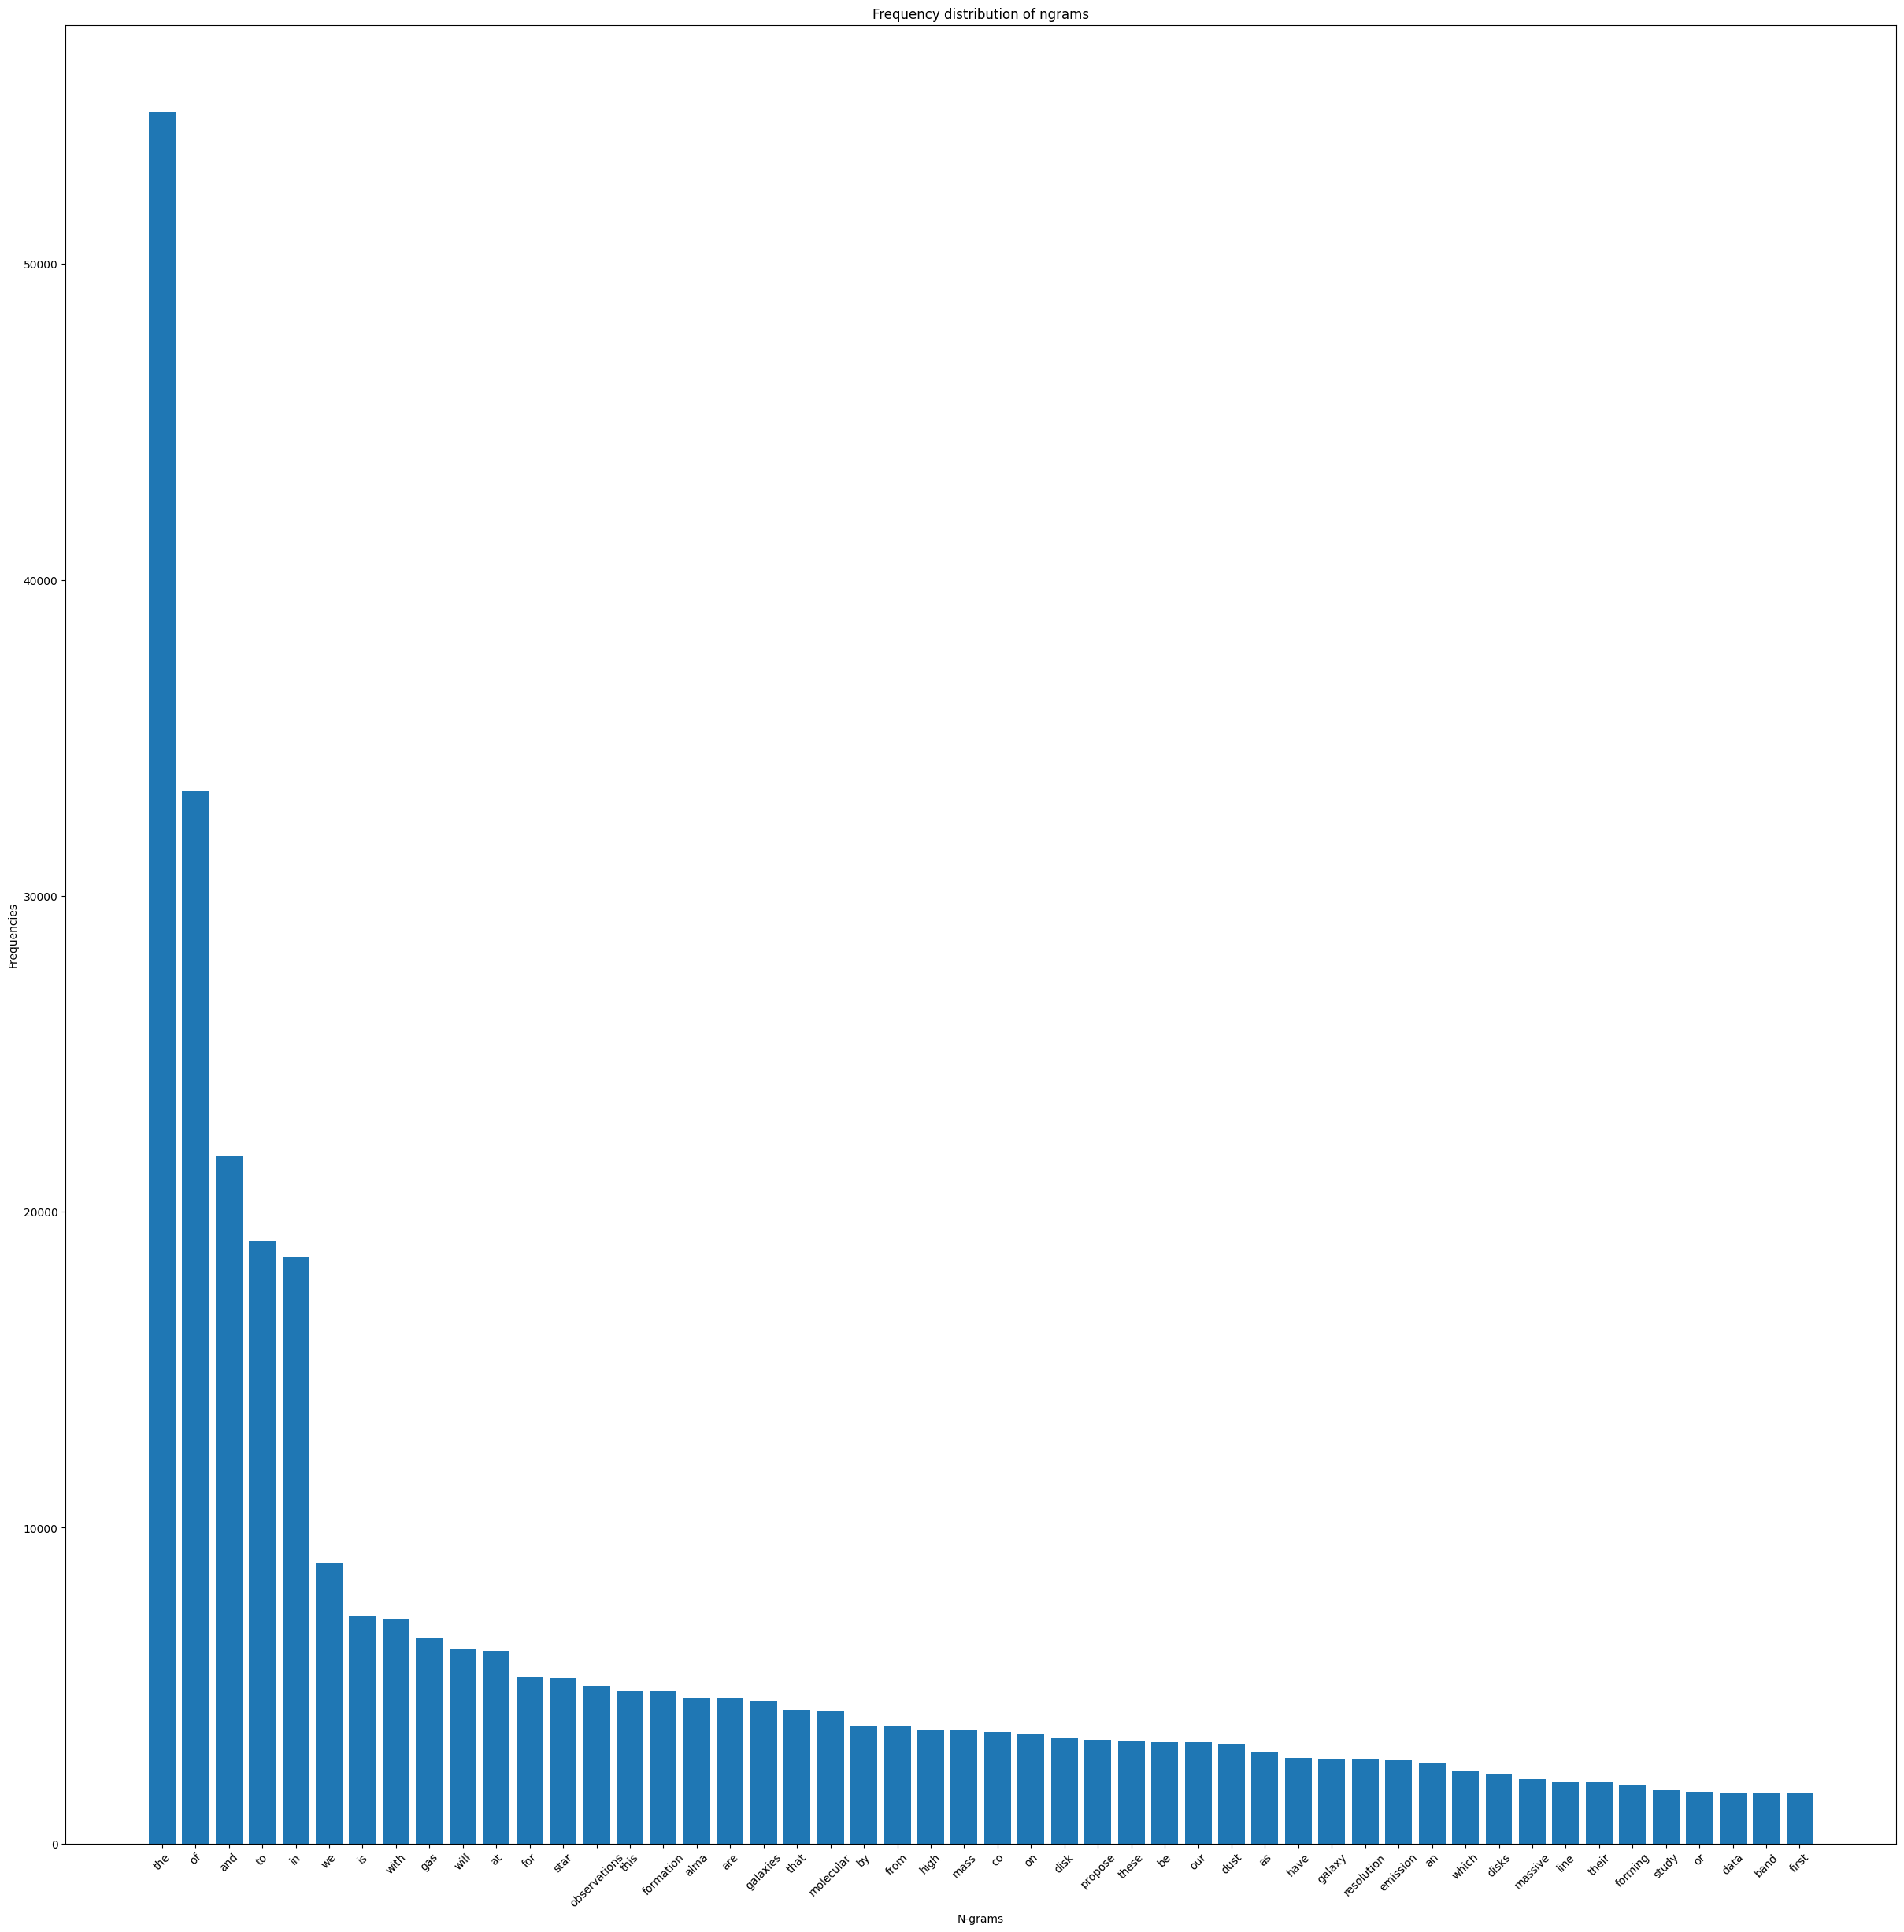

In [15]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(trX.astype('U'))
all_ngrams = vectorizer.get_feature_names_out()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [16]:
NGRAM_RANGE = (1, 10)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts.astype('U'))
    x_val = tfidf_vectorizer.transform(val_texts.astype('U'))
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [17]:
a, b = ngram_vectorize(trX, trY, ttX)
a

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


<4028x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 218990 stored elements in Compressed Sparse Row format>

## Build, Train and Evaluate the model

First, let's create a function that returns the appropriate number of units and the activation for the last layer.

In [18]:
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

Let's now create the model using the Keras API from tensorflow

In [19]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    #model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=op_units, activation=op_activation))
    return model

Now, let's train the model

In [20]:
def train_ngram_model(data, learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, 
                      dropout_rate=0.5):
    
    num_classes = 2
    
    # Get the data
    trX, trY, ttX, ttY = data
    
    # Verify the validation labels
    '''
    unexpected_labels = [v for v in ttY if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the labels'
                         ' in the validation set are in the same range as '
                         'training labels.'.format(unexpected_labels=unexpected_labels))
    '''
    
    # Vectorize the data
    x_train, x_val = ngram_vectorize(trX, trY, ttX)
    
    # Create model instance
    model = mlp_model(layers, units=units, dropout_rate=0.2, input_shape=x_train.shape[1:], num_classes=num_classes)
    
    # Compile model with parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    #optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])
    
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    
    # Train and validate model
    history = model.fit(x_train, trY, epochs=epochs, validation_data=(x_val, ttY),
                        verbose=2, batch_size=batch_size, callbacks=callbacks)
    
    # Print results
    history = history.history
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))
    
    # Save model
    #model.save('IMDB_mlp_model_' + str(val_acc) + '_' + str(loss) + '.h5')
    return val_acc, val_loss

In [21]:
random.seed = (seed)
results = train_ngram_model((trX, trY, ttX, ttY))

print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Epoch 1/1000
32/32 - 0s - loss: 0.6619 - acc: 0.7967 - val_loss: 0.6141 - val_acc: 0.7920 - 389ms/epoch - 12ms/step
Epoch 2/1000
32/32 - 0s - loss: 0.5847 - acc: 0.8141 - val_loss: 0.5284 - val_acc: 0.7920 - 131ms/epoch - 4ms/step
Epoch 3/1000
32/32 - 0s - loss: 0.5037 - acc: 0.8163 - val_loss: 0.4598 - val_acc: 0.7940 - 129ms/epoch - 4ms/step
Epoch 4/1000
32/32 - 0s - loss: 0.4402 - acc: 0.8222 - val_loss: 0.4119 - val_acc: 0.8060 - 132ms/epoch - 4ms/step
Epoch 5/1000
32/32 - 0s - loss: 0.3897 - acc: 0.8339 - val_loss: 0.3746 - val_acc: 0.8280 - 132ms/epoch - 4ms/step
Epoch 6/1000
32/32 - 0s - loss: 0.3494 - acc: 0.8548 - val_loss: 0.3483 - val_acc: 0.8460 - 133ms/epoch - 4ms/step
Epoch 7/1000
32/32 - 0s - loss: 0.3183 - acc: 0.8736 - val_loss: 0.3324 - val_acc: 0.8520 - 130ms/epoch - 4ms/step
Epoch 8/1000
32/32 - 0s - loss: 0.2925 - acc: 0.8878 - val_loss: 0.3235 - val_acc: 0.8620 - 132ms/epoch - 4ms/step
Epoch 9/1000
32/32 - 0s - loss: 0.2693 - acc: 0.8990 - val_loss: 0.3214 - val_a

In [22]:
results

(0.8740000128746033, 0.3261434733867645)